#### Load Data and Create TF Datasets

In [3]:
import json 
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

In [10]:
def create_filename_list(file_list, base_path = "Task09_Spleen/"):
    
    filenames = {}
    
    for idx in range(len(file_list)):
        filenames[idx] = [os.path.join(base_path, file_list[idx]['image']).replace("./",""), 
                         os.path.join(base_path, file_list[idx]['label']).replace("./","")]
    
    return filenames

In [14]:
def plot_image_mask_max(img, lbl):
    slicenum = np.argmax(np.sum(lbl, axis=(0,1)))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
    ax1.imshow(img[:,:,slicenum], cmap='gray', vmin=0, vmax=255)
    ax1.set_title('Image')
    plt.imshow(lbl[:,:,slicenum], cmap='gray', vmin=0, vmax=1)
    ax2.set_title('Mask')
    
def plot_image_mask(img, lbl, title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9, 4))
    ax1.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax1.set_title('Image')
    plt.imshow(lbl, cmap='gray', vmin=0, vmax=1)
    ax2.set_title('Mask')
    fig.suptitle(title, fontsize=16)

#### File Exploration

In [15]:
def get_slice_with_maximum_mask(lbl_arr):
    slice_num = np.argmax(np.sum(lbl_arr, axis=(0,1)))
    return slice_num
    
def convert_images_to_2d_and_stack(filenames, x_size = 512, y_size = 512):

    images = None
    labels = None
    
    for i in range(len(filenames)):
#     for i in range(5):
        
        imgFile = filenames[i][0]
        lblFile = filenames[i][1]
        
        img = np.array(nib.load(imgFile).get_fdata())
        lbl = np.array(nib.load(lblFile).get_fdata())
        
        img = np.expand_dims(img, axis = 2)
        lbl = np.expand_dims(lbl, axis = 2)
        
        if images is None and labels is None:
            images = img
            labels = lbl
        else:
            images = np.concatenate((images, img), axis = 3)
            labels = np.concatenate((labels, lbl), axis = 3)
        
    print(f"Size of All Image Array {images.shape}, Size of Label Array {labels.shape}")
    
    slicenum = random.randint(0, images.shape[3])
    plot_image_mask(images[:,:,:,slicenum], labels[:,:,:, slicenum], "Initial Load")
    return images, labels

def shuffle_data(images, labels):
    assert images.shape[3] == labels.shape[3]
    
    index_arr = np.arange(images.shape[3])
    np.random.shuffle(index_arr)
    
    images_shuff = np.expand_dims(images[:,:,:,index_arr[0]], axis = 3)
    labels_shuff = np.expand_dims(labels[:,:,:,index_arr[0]], axis = 3)
    
    for i in range(1, len(index_arr)):
        images_shuff = np.concatenate((images_shuff, np.expand_dims(images[:,:,:,index_arr[i]], axis = 3)), axis = 3)
        labels_shuff = np.concatenate((labels_shuff, np.expand_dims(labels[:,:,:,index_arr[i]], axis = 3)), axis = 3)
     
    slicenum = random.randint(0, images_shuff.shape[3])
    plot_image_mask(images_shuff[:,:,:,slicenum], labels_shuff[:,:,:, slicenum], "After Shuffle")
    return images_shuff, labels_shuff

def custom_moveaxis(image_arr, label_arr, from_pos, to_pos):
    images_re = np.moveaxis(image_arr, from_pos, to_pos) # Change dimension to n,x,y,z so that tf dataset takes the slices as separate data points
    labels_re = np.moveaxis(label_arr, from_pos, to_pos)
    
    return images_re, labels_re

def preprocess_files(image, label):
    
    #z-score-normalize
    #image = tf.image.per_image_standardization(image)
    
    #flip up down or flip left right on chance
    flip_up_down = random.randint(0, 1)
    
    if flip_up_down:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)
    else:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    
    
    #rotate
    k_value = random.randint(1,3)
    image = tf.image.rot90(image, k = k_value)
    label = tf.image.rot90(label, k = k_value)
    
    image = tf.image.resize(image, [512, 512])
    label = tf.image.resize(label, [512, 512])
    
    image = tf.image.resize_with_pad(image, 572, 572)
    label = tf.image.resize_with_pad(label, 572, 572)
    
    return image, label

def build_train_val_dataset(path = "Task09_Spleen/dataset.json", val_size = 0.25, from_ = 0, to_ = 10):
    datasetFile = None
    
    with open(path, "r") as jsonFile:
        datasetFile = json.load(jsonFile)
        
    filenames = datasetFile['training'][from_ : to_]
    filenames = np.array(filenames)
    random.shuffle(filenames)
    train, validation = train_test_split(filenames, test_size = 0.25)
    train_filenames = create_filename_list(list(train), "Task09_Spleen/")
    validation_filenames = create_filename_list(list(validation), "Task09_Spleen/")
    
    print(f"Number of train files : {len(train_filenames)}, Number of validation files : {len(validation_filenames)}")
    
    print("Read Files and load them as a stack")
    train_images, train_labels = convert_images_to_2d_and_stack(train_filenames)
    val_images, val_labels = convert_images_to_2d_and_stack(validation_filenames)

#     print("Shuffle Data")
#     train_images, train_labels = shuffle_data(train_images, train_labels)
#     val_images, val_labels = shuffle_data(val_images, val_labels)

    print("Move Axis")
    train_images, train_labels = custom_moveaxis(train_images, train_labels, -1, 0)
    val_images, val_labels = custom_moveaxis(val_images, val_labels, -1, 0)

    print(f"Train Img Shape : {train_images.shape}, Train Label Shape : {train_labels.shape}")
    print(f"Validation Img Shape : {train_images.shape}, Validation Label Shape : {train_labels.shape}")
    
    return train_images, train_labels, val_images, val_labels

def build_tf_dataset(train_images, train_labels, val_images, val_labels):
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    
    print(f"Length of Train Dataset : {len(train_dataset)}, Length of Validation Dataset : {len(val_dataset)}")
  
    for e in train_dataset.shuffle(len(train_dataset)).take(5):
        plot_image_mask(e[0].numpy(), e[1].numpy(),"Train TF Dataset")
        
    
    for e in val_dataset.shuffle(len(val_dataset)).take(5):
        plot_image_mask(e[0].numpy(), e[1].numpy(), "Validation TF Dataset")
    
    train_dataset = train_dataset.shuffle(len(train_dataset))
    train_dataset = train_dataset.map(preprocess_files, num_parallel_calls=4)
    
    val_dataset = val_dataset.shuffle(len(val_dataset))
    val_dataset = val_dataset.map(preprocess_files, num_parallel_calls=4)
    
  
    for e in train_dataset.shuffle(len(train_dataset)).take(5):
        plot_image_mask(e[0].numpy(), e[1].numpy(), "Train After Processing")
        
    
    for e in val_dataset.shuffle(len(val_dataset)).take(5):
        plot_image_mask(e[0].numpy(), e[1].numpy(), "Validation After Processing")
    
    return train_dataset, val_dataset


Build Train and Validation Datasets
Number of train files : 7, Number of validation files : 3
Read Files and load them as a stack
Size of All Image Array (512, 512, 1, 526), Size of Label Array (512, 512, 1, 526)
Size of All Image Array (512, 512, 1, 237), Size of Label Array (512, 512, 1, 237)
Move Axis
Train Img Shape : (526, 512, 512, 1), Train Label Shape : (526, 512, 512, 1)
Validation Img Shape : (526, 512, 512, 1), Validation Label Shape : (526, 512, 512, 1)
Length of Train Dataset : 526, Length of Validation Dataset : 237


/var/folders/rx/wxbjj2r112s5dxn5zxlv7wv40000gn/T/ipykernel_995/2794452829.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9, 4))


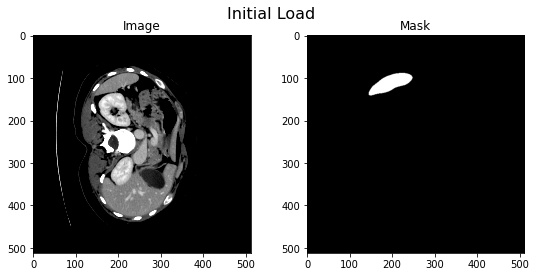

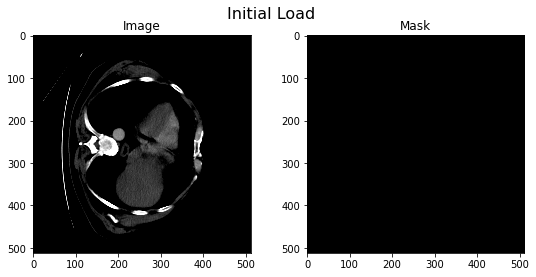

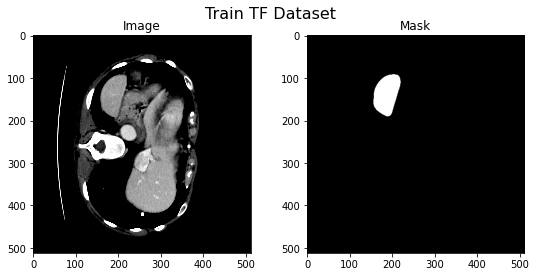

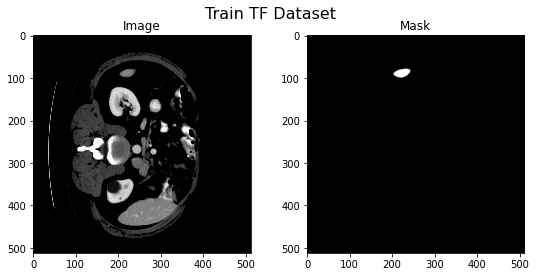

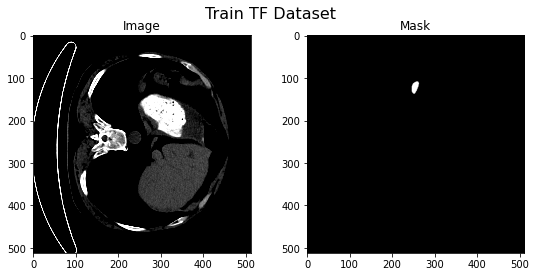

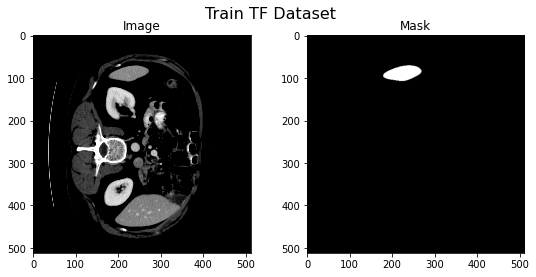

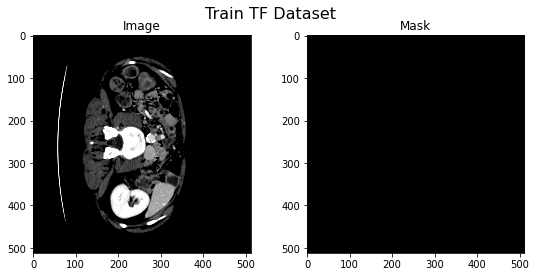

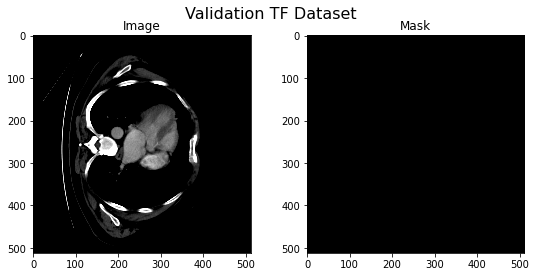

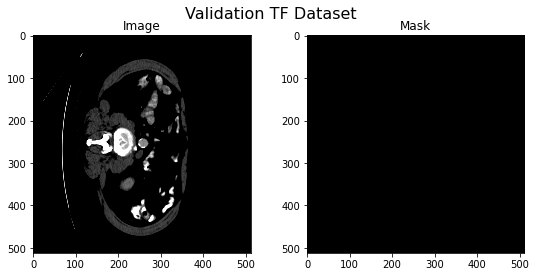

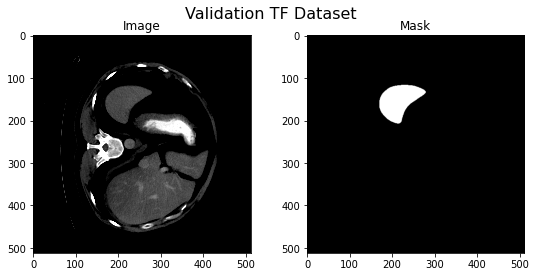

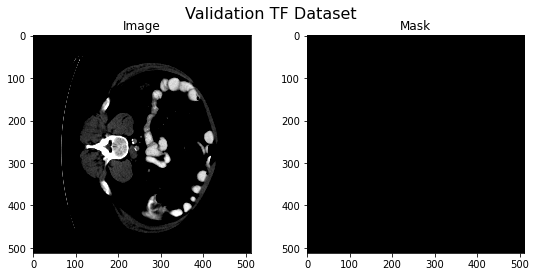

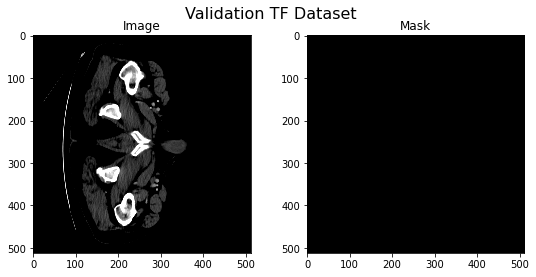

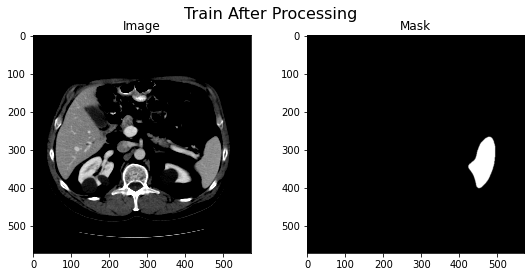

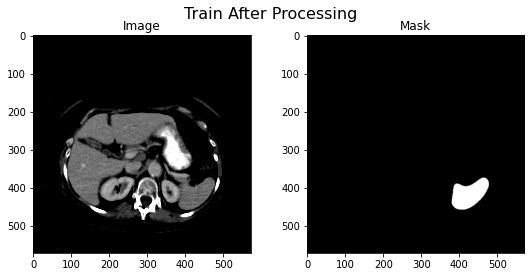

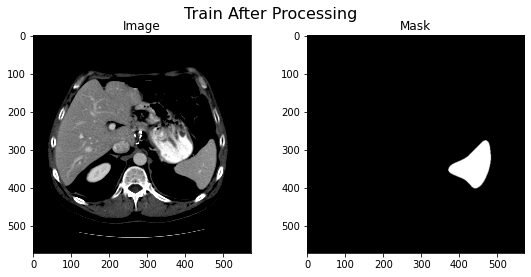

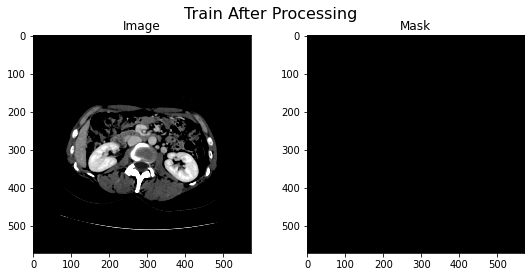

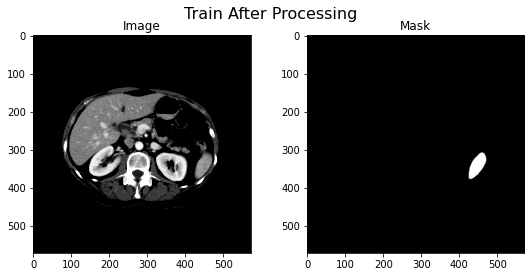

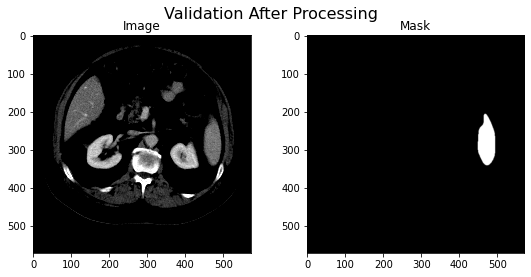

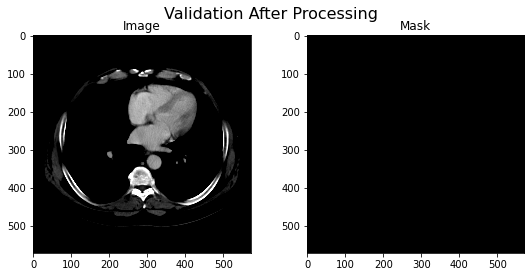

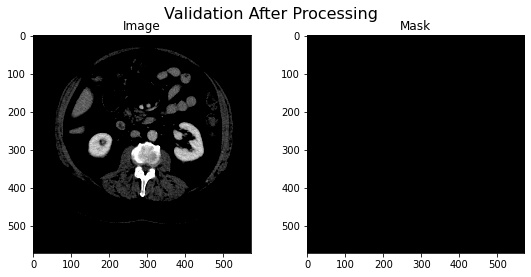

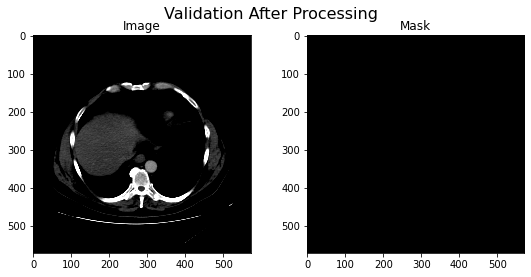

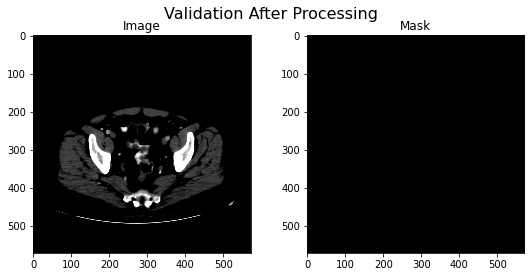

In [16]:
print("Build Train and Validation Datasets")
train_images, train_labels, val_images, val_labels = build_train_val_dataset(path = "Task09_Spleen/dataset.json", val_size = 0.25)
train_dataset, validation_dataset = build_tf_dataset(train_images, train_labels, val_images, val_labels)


### Build Unet Model

In [17]:
from tensorflow import keras as K

In [18]:
image_shape = None
label_shape = None
for e in train_dataset.take(1):
    image_shape = e[0].shape
    label_shape = e[1].shape

In [19]:
def input_block(image_shape, block_num = 1, filters = 64):
    print(f"*********** Block : {block_num} ***********")
    inputsLayer1 = K.Input(image_shape, name = "InputStep")
    print(f"Input Shape : {inputsLayer1.shape}")
    conv2DLayer2 = K.layers.Conv2D(filters = filters, kernel_size = (3,3), activation = 'relu')(inputsLayer1)
    print(f"Layer 2 Shape : {conv2DLayer2.shape}")
    conv2DLayer3 = K.layers.Conv2D(filters = filters, kernel_size = (3,3), activation = 'relu')(conv2DLayer2)
    print(f"Layer 3 Shape : {conv2DLayer3.shape}")
    
    return inputsLayer1, conv2DLayer3

def encoder_mp_conv_block(prev_layer, block_num = 2, filters = 128):
    print(f"*********** Encode Block : {block_num} ***********")
    maxPooling2DLayer1 = K.layers.MaxPool2D(pool_size = (2,2))(prev_layer)
    print(f"Max Pooling 2D Layer 1 Shape : {maxPooling2DLayer1.shape}")
    conv2DLayer2 = K.layers.Conv2D(filters = filters, kernel_size = (3,3), activation = 'relu')(maxPooling2DLayer1)
    print(f"Conv 2D Layer 2 Shape : {conv2DLayer2.shape}")
    conv2DLayer3 = K.layers.Conv2D(filters = filters, kernel_size = (3,3), activation = 'relu')(conv2DLayer2)
    print(f"Conv 2D Layer 3 Shape : {conv2DLayer3.shape}")
    
    return conv2DLayer3

def decoder_up_conv_block(prev_layer, encode_layer, block_num = 4, filters = 512):
    print(f"*********** Decode Block : {block_num} ***********")
    upConv2DLayer0 = K.layers.Conv2DTranspose(filters = filters, kernel_size = (2,2), strides = (2,2))(prev_layer)
    print(f"Up Conv 2D Layer 0 Shape : {upConv2DLayer0.shape}")
    resizedEncode2DLayer0 = K.layers.Resizing(height = upConv2DLayer0.shape[1], width = upConv2DLayer0.shape[2])(encode_layer)
    print(f"Resized Encode Layer {block_num} Shape : {resizedEncode2DLayer0.shape}")
    concatLayer = K.layers.concatenate([upConv2DLayer0, resizedEncode2DLayer0], axis = -1)
    print(f"Concatenated Layer 1 Shape : {concatLayer.shape}")
    conv2DLayer2 = K.layers.Conv2D(filters = filters, kernel_size = (3,3), activation = 'relu')(concatLayer)
    print(f"Conv 2D Layer 2 Shape : {conv2DLayer2.shape}")
    conv2DLayer3 = K.layers.Conv2D(filters = filters, kernel_size = (3,3), activation = 'relu')(conv2DLayer2)
    print(f"Conv 2D Layer 3 Shape : {conv2DLayer3.shape}")
    
    return conv2DLayer3

def output_layer(prev_layer, filters = 2, activation = 'sigmoid'):
    print(f"*********** Output Block ***********")
    conv2DOut = K.layers.Conv2D(filters = filters, kernel_size = (1,1), activation = activation)(prev_layer)
    print(f"Output Layer Shape : {conv2DOut.shape}")
    
    return conv2DOut
    

In [20]:
inputs, block1_op_layer = input_block(image_shape, block_num = 1, filters = 64)
encode_block2_op_layer = encoder_mp_conv_block(block1_op_layer, block_num = 2, filters = 128)
encode_block3_op_layer = encoder_mp_conv_block(encode_block2_op_layer, block_num = 3, filters = 256)
encode_block4_op_layer = encoder_mp_conv_block(encode_block3_op_layer, block_num = 4, filters = 512)
encode_block5_op_layer = encoder_mp_conv_block(encode_block4_op_layer, block_num = 5, filters = 1024)
decode_block4_op_layer = decoder_up_conv_block(encode_block5_op_layer, encode_block4_op_layer, block_num = 4, filters = 512)
decode_block3_op_layer = decoder_up_conv_block(decode_block4_op_layer, encode_block3_op_layer, block_num = 3, filters = 256)
decode_block2_op_layer = decoder_up_conv_block(decode_block3_op_layer, encode_block2_op_layer, block_num = 2, filters = 128)
decode_block1_op_layer = decoder_up_conv_block(decode_block2_op_layer, block1_op_layer, block_num = 1, filters = 64)
output_layer = output_layer(decode_block1_op_layer, filters = 2, activation = 'sigmoid')

*********** Block : 1 ***********
Input Shape : (None, 572, 572, 1)
Layer 2 Shape : (None, 570, 570, 64)
Layer 3 Shape : (None, 568, 568, 64)
*********** Encode Block : 2 ***********
Max Pooling 2D Layer 1 Shape : (None, 284, 284, 64)
Conv 2D Layer 2 Shape : (None, 282, 282, 128)
Conv 2D Layer 3 Shape : (None, 280, 280, 128)
*********** Encode Block : 3 ***********
Max Pooling 2D Layer 1 Shape : (None, 140, 140, 128)
Conv 2D Layer 2 Shape : (None, 138, 138, 256)
Conv 2D Layer 3 Shape : (None, 136, 136, 256)
*********** Encode Block : 4 ***********
Max Pooling 2D Layer 1 Shape : (None, 68, 68, 256)
Conv 2D Layer 2 Shape : (None, 66, 66, 512)
Conv 2D Layer 3 Shape : (None, 64, 64, 512)
*********** Encode Block : 5 ***********
Max Pooling 2D Layer 1 Shape : (None, 32, 32, 512)
Conv 2D Layer 2 Shape : (None, 30, 30, 1024)
Conv 2D Layer 3 Shape : (None, 28, 28, 1024)
*********** Decode Block : 4 ***********
Up Conv 2D Layer 0 Shape : (None, 56, 56, 512)
Resized Encode Layer 4 Shape : (None,

In [21]:
def dice_coeff_metric(ground_truth, prediction, axis = (1,2), smooth = 0.0001):
    
    intersection = tf.math.reduce_sum(ground_truth * prediction, axis = axis)
    numerator = (tf.constant(2.0) * intersection) + smooth
    denominator = tf.math.reduce_sum(tf.math.square(ground_truth), axis = axis) + tf.math.reduce_sum(tf.math.square(prediction), axis = axis)
    denominator = denominator + smooth
    dice_coeff = numerator/denominator
    
    return dice_coeff

def dice_loss():
    
    intersection = tf.math.reduce_sum(ground_truth * prediction, axis = axis)
    numerator = (tf.constant(2.0) * intersection) + smooth
    denominator = tf.math.reduce_sum(tf.math.square(ground_truth), axis = axis) + tf.math.reduce_sum(tf.math.square(prediction), axis = axis)
    denominator = denominator + smooth
    dice_loss = -tf.math.log(numerator) + tf.math.log(denominator)
    
    return dice_loss

In [22]:
model = K.models.Model(inputs = [inputs], outputs = [output_layer], name = "2D_Unet_Model")
model.compile(optimizer = K.optimizers.Adam(learning_rate = 0.0003),
             loss = dice_loss,
             metrics = dice_coeff_metric)
model.summary()

Model: "2D_Unet_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputStep (InputLayer)          [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 640         InputStep[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________

#### Questions:

1. Some implementations do not have the square below while some have 
2. 

In [23]:
model.fit(train_dataset, epochs=4, validation_data=validation_dataset, verbose=1)

Epoch 1/4


ValueError: in user code:

    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/layers/convolutional.py:249 call
        outputs = self._convolution_op(inputs, self.kernel)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:1131 convolution_v2
        return convolution_internal(
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:1261 convolution_internal
        return op(
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:2715 _conv2d_expanded_batch
        return gen_nn_ops.conv2d(
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/ops/gen_nn_ops.py:969 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /Users/roshanjoe/miniforge3/envs/mlp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 3 from 1 for '{{node 2D_Unet_Model/conv2d/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](2D_Unet_Model/ExpandDims, 2D_Unet_Model/conv2d/Conv2D/ReadVariableOp)' with input shapes: [572,572,1,1], [3,3,1,64].


In [6]:
new_list = [1,2,3]
new_list[0:2]

[1, 2]